In [2]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np
import requests
import json

In [2]:
# import rail isochrones
rail_isochrone = gpd.read_file(os.path.join('data','cleaned','rail_isochrone_15m.gpkg'),crs='EPSG:27700')
rail_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   400 non-null    int64   
 1   name      400 non-null    object  
 2   pt_type   400 non-null    object  
 3   geometry  400 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 12.6+ KB


In [3]:
# import bus isochrones
bus_isochrone = gpd.read_file(os.path.join('data','cleaned','bus_isochrone_15m.gpkg'),crs='EPSG:27700')
bus_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16942 entries, 0 to 16941
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   16942 non-null  object  
 1   name      16942 non-null  object  
 2   pt_type   16942 non-null  object  
 3   geometry  16942 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 529.6+ KB


In [4]:
# add prefix to column id_code of each df
rail_isochrone['id_code'] = 'R_' + rail_isochrone['id_code'].astype(str)
bus_isochrone['id_code'] = 'B_' + bus_isochrone['id_code'].astype(str)

In [5]:
# concatenate isochrones
isochrones = pd.concat([rail_isochrone,bus_isochrone])
# reset index
isochrones.reset_index(drop=True,inplace=True)

Load Railway station (by opt) location data

In [6]:
df = pd.read_csv(os.path.join('data','raw','tfl','Station - 2011-12.csv'))
df = df[df['County or Unitary Authority'] == 'Greater London'] # Filter for London
# create new column for postcode, trim last 3 characters of the location for map
df['Postcode'] = df['Location for map'].str[:-4]
# remove London Underground and London Overground stations in Station Facility Owner
df = df[~df['Station Facility Owner'].str.contains('London Underground')]
df = df[~df['Station Facility Owner'].str.contains('London Overground')]
df.head()

,NLC,Origin TLC,Station Name,Location for map,Government Office Region (GOR),County or Unitary Authority,District or Unitary Authority,NUTS2 Spatial_Unit Code,NUTS2 Spatial Unit,Station Facility Owner,London Travelcard Area,Postcode
0,7492,BKG,Barking,"IG11 8TU, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,IG11 8TU
19,7440,DDK,Dagenham Dock,"RM9 6PT, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,RM9 6PT
20,7491,LHS,Limehouse,"E14 7JD, UK",London,Greater London,Tower Hamlets,UKI1,Inner London,c2c,London Travelcard Area Station,E14 7JD
33,7454,RNM,Rainham (Essex),"RM13 9HY, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM13 9HY
39,7464,UPM,Upminster,"RM14 2TD, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM14 2TD


In [7]:
df['Station Facility Owner'].value_counts()

Station Facility Owner
Southeastern                    68
Southern                        51
National Express East Anglia    40
South West Trains               39
First Capital Connect           37
Network Rail                    11
First Great Western             10
Chiltern Railways                7
c2c                              6
Name: count, dtype: int64

In [8]:
def get_lat_long(postcode):
    url = f'https://api.postcodes.io/postcodes/{postcode}'
    response = requests.get(url)
    if response.status_code == 200:
        data = json.loads(response.text)
        return data['result']['latitude'], data['result']['longitude']
    else:
        return np.nan, np.nan
    
# test function
df['Latlon'] = df['Postcode'].apply(get_lat_long) 
df.head()   

,NLC,Origin TLC,Station Name,Location for map,Government Office Region (GOR),County or Unitary Authority,District or Unitary Authority,NUTS2 Spatial_Unit Code,NUTS2 Spatial Unit,Station Facility Owner,London Travelcard Area,Postcode,Latlon
0,7492,BKG,Barking,"IG11 8TU, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,IG11 8TU,"(51.539322, 0.080979)"
19,7440,DDK,Dagenham Dock,"RM9 6PT, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,RM9 6PT,"(nan, nan)"
20,7491,LHS,Limehouse,"E14 7JD, UK",London,Greater London,Tower Hamlets,UKI1,Inner London,c2c,London Travelcard Area Station,E14 7JD,"(51.512605, -0.040203)"
33,7454,RNM,Rainham (Essex),"RM13 9HY, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM13 9HY,"(51.512476, 0.20085)"
39,7464,UPM,Upminster,"RM14 2TD, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM14 2TD,"(51.558504, 0.250535)"


In [9]:
# geo data frame
df[['Latitude','Longitude']] = pd.DataFrame(df['Latlon'].tolist(), index=df.index)
rail_opt = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')
rail_opt = rail_opt.to_crs('EPSG:27700')

rail_opt = rail_opt[['NLC','Station Name','Station Facility Owner','geometry']]

# rename columns
rail_opt.columns = ['nlc','name','operator','geometry']
rail_opt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 269 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       269 non-null    int64   
 1   name      269 non-null    object  
 2   operator  269 non-null    object  
 3   geometry  269 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 10.5+ KB


In [10]:
# TFL stations
df1 = pd.read_csv(os.path.join('data','raw','tfl','numbat_geometry.csv'))
# GEO data frame
df1['geometry'] = gpd.GeoSeries.from_wkt(df1['geometry'])
rail_opt_tfl = gpd.GeoDataFrame(df1, crs='EPSG:4326')
rail_opt_tfl = rail_opt_tfl.to_crs('EPSG:27700')
rail_opt_tfl['operator'] = 'TfL'
rail_opt_tfl = rail_opt_tfl.drop(columns=['asc'])
# rename columns
rail_opt_tfl.columns = ['nlc','name','geometry','operator']
rail_opt_tfl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       432 non-null    int64   
 1   name      432 non-null    object  
 2   geometry  432 non-null    geometry
 3   operator  432 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 13.6+ KB


In [11]:
# concat
rail_stn_op = pd.concat([rail_opt,rail_opt_tfl],ignore_index=True)
rail_stn_op = rail_stn_op[rail_stn_op['geometry'].is_empty == False]
rail_stn_op.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 668 entries, 0 to 700
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       668 non-null    int64   
 1   name      668 non-null    object  
 2   operator  668 non-null    object  
 3   geometry  668 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 26.1+ KB


In [13]:
bus_route = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStopRoutes.gpkg'))
bus_route.to_crs('EPSG:27700',inplace=True)
bus_route.head()

,stop_id,stop_name,route_id,Total,geometry
0,1000,Westminster Stn / Parliament Square,12,38.75,POINT (530171.000 179738.000)
1,1000,Westminster Stn / Parliament Square,159,58.25,POINT (530171.000 179738.000)
2,1000,Westminster Stn / Parliament Square,453,88.75,POINT (530171.000 179738.000)
3,1000,Westminster Stn / Parliament Square,N453,8.25,POINT (530171.000 179738.000)
4,10001,Trevor Close,481,2.50,POINT (515781.000 174783.000)


Aggregate bus stops by routes served

In [14]:
# loop through each isochrone
for i, isochrone in isochrones.iterrows():
    # create a list to store the route_ids
    route_ids = []
    # get the stops that are within the isochrone
    stops_within = bus_route[bus_route.geometry.within(isochrone.geometry)]
    # get the route_ids for those stops
    route_ids.extend(stops_within['route_id'].unique())
    route_ids = list(set(route_ids))
    # create new column in the original df to store the route_ids
    isochrones.loc[i,'route_ids'] = str(route_ids)
    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(isochrones)} processed')

0 of 17342 processed
100 of 17342 processed
200 of 17342 processed
300 of 17342 processed
400 of 17342 processed
500 of 17342 processed
600 of 17342 processed
700 of 17342 processed
800 of 17342 processed
900 of 17342 processed
1000 of 17342 processed
1100 of 17342 processed
1200 of 17342 processed
1300 of 17342 processed
1400 of 17342 processed
1500 of 17342 processed
1600 of 17342 processed
1700 of 17342 processed
1800 of 17342 processed
1900 of 17342 processed
2000 of 17342 processed
2100 of 17342 processed
2200 of 17342 processed
2300 of 17342 processed
2400 of 17342 processed
2500 of 17342 processed
2600 of 17342 processed
2700 of 17342 processed
2800 of 17342 processed
2900 of 17342 processed
3000 of 17342 processed
3100 of 17342 processed
3200 of 17342 processed
3300 of 17342 processed
3400 of 17342 processed
3500 of 17342 processed
3600 of 17342 processed
3700 of 17342 processed
3800 of 17342 processed
3900 of 17342 processed
4000 of 17342 processed
4100 of 17342 processed
4200

Aggregate rail stations by operators

In [15]:
# loop through each isochrone
for i, isochrone in isochrones.iterrows():
    # create a list to store the route_ids
    route_ids1 = []
    # get the stops that are within the isochrone
    stops_within = rail_stn_op[rail_stn_op.geometry.within(isochrone.geometry)]
    # get the route_ids for those stops
    route_ids1.extend(stops_within['operator'].unique())
    route_ids1 = list(set(route_ids1))
    # create new column in the original df to store the route_ids
    isochrones.loc[i,'route_ids1'] = str(route_ids1)
    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(isochrones)} processed')

0 of 17342 processed
100 of 17342 processed
200 of 17342 processed
300 of 17342 processed
400 of 17342 processed
500 of 17342 processed
600 of 17342 processed
700 of 17342 processed
800 of 17342 processed
900 of 17342 processed
1000 of 17342 processed
1100 of 17342 processed
1200 of 17342 processed
1300 of 17342 processed
1400 of 17342 processed
1500 of 17342 processed
1600 of 17342 processed
1700 of 17342 processed
1800 of 17342 processed
1900 of 17342 processed
2000 of 17342 processed
2100 of 17342 processed
2200 of 17342 processed
2300 of 17342 processed
2400 of 17342 processed
2500 of 17342 processed
2600 of 17342 processed
2700 of 17342 processed
2800 of 17342 processed
2900 of 17342 processed
3000 of 17342 processed
3100 of 17342 processed
3200 of 17342 processed
3300 of 17342 processed
3400 of 17342 processed
3500 of 17342 processed
3600 of 17342 processed
3700 of 17342 processed
3800 of 17342 processed
3900 of 17342 processed
4000 of 17342 processed
4100 of 17342 processed
4200

Aggregate other transport hubs

In [3]:
# import transp_opt_isochrones_full.csv
isochrones1 = pd.read_csv(os.path.join('data','cleaned','transp_opt_isochrones_full.csv'))

In [4]:
# geodataframe
isochrones1['geometry'] = gpd.GeoSeries.from_wkt(isochrones1['geometry'],crs='EPSG:27700')
isochrones1 = gpd.GeoDataFrame(isochrones1, crs='EPSG:27700')
isochrones1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    17342 non-null  object  
 1   name                       17342 non-null  object  
 2   pt_type                    17342 non-null  object  
 3   geometry                   17342 non-null  geometry
 4   route_ids                  17342 non-null  object  
 5   route_ids1                 17342 non-null  object  
 6   route_ids2                 17342 non-null  int64   
 7   transp_opt_entropy         17342 non-null  float64 
 8   transp_opt_entropy_wo_hub  17342 non-null  float64 
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 1.2+ MB


In [5]:
isochrones = isochrones1.copy()
isochrones.head()

,id_code,name,pt_type,geometry,route_ids,route_ids1,route_ids2,transp_opt_entropy,transp_opt_entropy_wo_hub
0,R_750,Abbey Road,rail,"POLYGON ((538894.554 183025.869, 538893.934 18...",['276'],['TfL'],0,0.693147,0.693147
1,R_5131,Abbey Wood,rail,"POLYGON ((546817.720 178994.762, 546815.775 17...","['229', 'B11', 'N472', '180', 'N1', '472', '24...","['Southeastern', 'TfL']",0,2.397895,2.397895
2,R_1404,Acton Central,rail,"POLYGON ((520076.256 180087.693, 520076.059 18...","['95', '207', '218', 'N207', '70', 'N11', '260...",[],0,2.639057,2.639057
3,R_3000,Acton Main Line,rail,"POLYGON ((520167.664 180775.840, 520165.727 18...","['95', '218', '70', '260', '272', '266', '440'...","['TfL', 'First Great Western']",0,2.484907,2.484907
4,R_500,Acton Town,rail,"POLYGON ((518842.951 178561.693, 518840.651 17...","['N207', '218', '207', '70', 'N11', '266', 'E3...",['TfL'],0,2.397895,2.397895


In [6]:
# load poi_pop
poi_pop_h3 = gpd.read_file(os.path.join('data','cleaned','poi_pop_h3_r10.gpkg'),crs='EPSG:27700')
# filter transport_other and geometry columns
transport_hub = poi_pop_h3[['transport_other','geometry']]

In [7]:
%%time
# loop through each isochrone and get the sum of the transport_other within the isochrone
for i, isochrone in isochrones.iterrows():
    # get the transport_other that are within the isochrone
    transport_within = transport_hub[transport_hub.geometry.within(isochrone.geometry)]
    # get the sum of the transport_other for those stops
    isochrones.loc[i,'route_ids2'] = transport_within['transport_other'].sum()
    
    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(isochrones)} processed')

0 of 17342 processed
100 of 17342 processed
200 of 17342 processed
300 of 17342 processed
400 of 17342 processed
500 of 17342 processed
600 of 17342 processed
700 of 17342 processed
800 of 17342 processed
900 of 17342 processed
1000 of 17342 processed
1100 of 17342 processed
1200 of 17342 processed
1300 of 17342 processed
1400 of 17342 processed
1500 of 17342 processed
1600 of 17342 processed
1700 of 17342 processed
1800 of 17342 processed
1900 of 17342 processed
2000 of 17342 processed
2100 of 17342 processed
2200 of 17342 processed
2300 of 17342 processed
2400 of 17342 processed
2500 of 17342 processed
2600 of 17342 processed
2700 of 17342 processed
2800 of 17342 processed
2900 of 17342 processed
3000 of 17342 processed
3100 of 17342 processed
3200 of 17342 processed
3300 of 17342 processed
3400 of 17342 processed
3500 of 17342 processed
3600 of 17342 processed
3700 of 17342 processed
3800 of 17342 processed
3900 of 17342 processed
4000 of 17342 processed
4100 of 17342 processed
4200

In [16]:
isochrones['route_ids2'] = isochrones['route_ids2'].astype(int)
isochrones.head()

,id_code,name,pt_type,geometry,route_ids,route_ids1,route_ids2,transp_opt_entropy,transp_opt_entropy_wo_hub
0,R_750,Abbey Road,rail,"POLYGON ((538894.554 183025.869, 538893.934 18...",['276'],['TfL'],0,0.693147,0.693147
1,R_5131,Abbey Wood,rail,"POLYGON ((546817.720 178994.762, 546815.775 17...","['229', 'B11', 'N472', '180', 'N1', '472', '24...","['Southeastern', 'TfL']",0,2.397895,2.397895
2,R_1404,Acton Central,rail,"POLYGON ((520076.256 180087.693, 520076.059 18...","['95', '207', '218', 'N207', '70', 'N11', '260...",[],0,2.639057,2.639057
3,R_3000,Acton Main Line,rail,"POLYGON ((520167.664 180775.840, 520165.727 18...","['95', '218', '70', '260', '272', '266', '440'...","['TfL', 'First Great Western']",0,2.484907,2.484907
4,R_500,Acton Town,rail,"POLYGON ((518842.951 178561.693, 518840.651 17...","['N207', '218', '207', '70', 'N11', '266', 'E3...",['TfL'],0,2.397895,2.397895


Calculate entropy

In [8]:
from scipy.stats import entropy

In [9]:
# iterate through each row
for i, row in isochrones.iterrows():
    # convert the string back to a list
    c = eval(row['route_ids'])
    d = eval(row['route_ids1'])
    
    # convert route_ids2 to a list of number of elements
    e = row['route_ids2'] 
    e = np.ones(e)

    # combine the two lists
    c.extend(d)
    # count the frequency of each element, 
    c = np.array([c.count(x) for x in set(c)])
    c = np.append(c,e)

    # then calculate the probability
    c = c[c != 0]
    c = c / c.sum()

    # calculate the entropy
    ent = entropy(c)
    # add to the original df
    isochrones.loc[i,'transp_opt_entropy'] = ent

    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(isochrones)} processed')

isochrones.head() 

0 of 17342 processed
100 of 17342 processed
200 of 17342 processed
300 of 17342 processed
400 of 17342 processed
500 of 17342 processed
600 of 17342 processed
700 of 17342 processed
800 of 17342 processed
900 of 17342 processed
1000 of 17342 processed
1100 of 17342 processed
1200 of 17342 processed
1300 of 17342 processed
1400 of 17342 processed
1500 of 17342 processed
1600 of 17342 processed
1700 of 17342 processed
1800 of 17342 processed
1900 of 17342 processed
2000 of 17342 processed
2100 of 17342 processed
2200 of 17342 processed
2300 of 17342 processed
2400 of 17342 processed
2500 of 17342 processed
2600 of 17342 processed
2700 of 17342 processed
2800 of 17342 processed
2900 of 17342 processed
3000 of 17342 processed
3100 of 17342 processed
3200 of 17342 processed
3300 of 17342 processed
3400 of 17342 processed
3500 of 17342 processed
3600 of 17342 processed
3700 of 17342 processed
3800 of 17342 processed
3900 of 17342 processed
4000 of 17342 processed
4100 of 17342 processed
4200

,id_code,name,pt_type,geometry,route_ids,route_ids1,route_ids2,transp_opt_entropy,transp_opt_entropy_wo_hub
0,R_750,Abbey Road,rail,"POLYGON ((538894.554 183025.869, 538893.934 18...",['276'],['TfL'],0,0.693147,0.693147
1,R_5131,Abbey Wood,rail,"POLYGON ((546817.720 178994.762, 546815.775 17...","['229', 'B11', 'N472', '180', 'N1', '472', '24...","['Southeastern', 'TfL']",0,2.397895,2.397895
2,R_1404,Acton Central,rail,"POLYGON ((520076.256 180087.693, 520076.059 18...","['95', '207', '218', 'N207', '70', 'N11', '260...",[],0,2.639057,2.639057
3,R_3000,Acton Main Line,rail,"POLYGON ((520167.664 180775.840, 520165.727 18...","['95', '218', '70', '260', '272', '266', '440'...","['TfL', 'First Great Western']",0,2.484907,2.484907
4,R_500,Acton Town,rail,"POLYGON ((518842.951 178561.693, 518840.651 17...","['N207', '218', '207', '70', 'N11', '266', 'E3...",['TfL'],0,2.397895,2.397895


In [10]:
# iterate through each row
for i, row in isochrones.iterrows():
    # convert the string back to a list
    c = eval(row['route_ids'])
    d = eval(row['route_ids1'])

    # combine the two lists
    c.extend(d)
    
    # count the frequency of each element, 
    c = np.array([c.count(x) for x in set(c)])

    # then calculate the probability
    c = c[c != 0]
    c = c / c.sum()

    # calculate the entropy
    ent = entropy(c)
    # add to the original df
    isochrones.loc[i,'transp_opt_entropy_wo_hub'] = ent

    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(isochrones)} processed')

isochrones.head()   

0 of 17342 processed
100 of 17342 processed
200 of 17342 processed
300 of 17342 processed
400 of 17342 processed
500 of 17342 processed
600 of 17342 processed
700 of 17342 processed
800 of 17342 processed
900 of 17342 processed
1000 of 17342 processed
1100 of 17342 processed
1200 of 17342 processed
1300 of 17342 processed
1400 of 17342 processed
1500 of 17342 processed
1600 of 17342 processed
1700 of 17342 processed
1800 of 17342 processed
1900 of 17342 processed
2000 of 17342 processed
2100 of 17342 processed
2200 of 17342 processed
2300 of 17342 processed
2400 of 17342 processed
2500 of 17342 processed
2600 of 17342 processed
2700 of 17342 processed
2800 of 17342 processed
2900 of 17342 processed
3000 of 17342 processed
3100 of 17342 processed
3200 of 17342 processed
3300 of 17342 processed
3400 of 17342 processed
3500 of 17342 processed
3600 of 17342 processed
3700 of 17342 processed
3800 of 17342 processed
3900 of 17342 processed
4000 of 17342 processed
4100 of 17342 processed
4200

,id_code,name,pt_type,geometry,route_ids,route_ids1,route_ids2,transp_opt_entropy,transp_opt_entropy_wo_hub
0,R_750,Abbey Road,rail,"POLYGON ((538894.554 183025.869, 538893.934 18...",['276'],['TfL'],0,0.693147,0.693147
1,R_5131,Abbey Wood,rail,"POLYGON ((546817.720 178994.762, 546815.775 17...","['229', 'B11', 'N472', '180', 'N1', '472', '24...","['Southeastern', 'TfL']",0,2.397895,2.397895
2,R_1404,Acton Central,rail,"POLYGON ((520076.256 180087.693, 520076.059 18...","['95', '207', '218', 'N207', '70', 'N11', '260...",[],0,2.639057,2.639057
3,R_3000,Acton Main Line,rail,"POLYGON ((520167.664 180775.840, 520165.727 18...","['95', '218', '70', '260', '272', '266', '440'...","['TfL', 'First Great Western']",0,2.484907,2.484907
4,R_500,Acton Town,rail,"POLYGON ((518842.951 178561.693, 518840.651 17...","['N207', '218', '207', '70', 'N11', '266', 'E3...",['TfL'],0,2.397895,2.397895


<Axes: title={'center': 'Top 10% Transport option diversity - PT only'}>

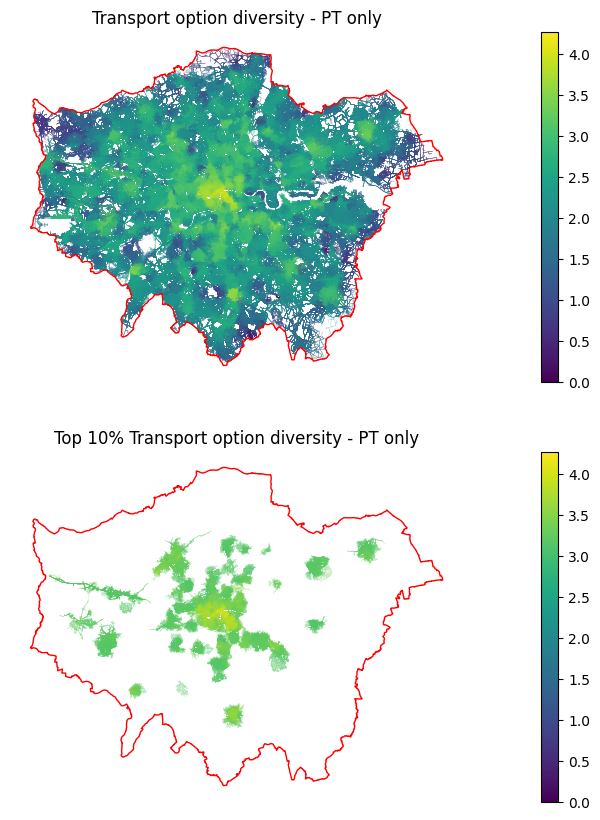

In [15]:
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = isochrones.transp_opt_entropy_wo_hub.min()
vmax = isochrones.transp_opt_entropy_wo_hub.max()

isochrones.plot(column='transp_opt_entropy_wo_hub', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('Transport option diversity - PT only')
ax[0].axis('off')

isochrones[isochrones.transp_opt_entropy_wo_hub > isochrones.transp_opt_entropy_wo_hub.quantile(0.90)].plot(
            column='transp_opt_entropy_wo_hub', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% Transport option diversity - PT only')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

<Axes: title={'center': 'Top 10% Transport option diversity'}>

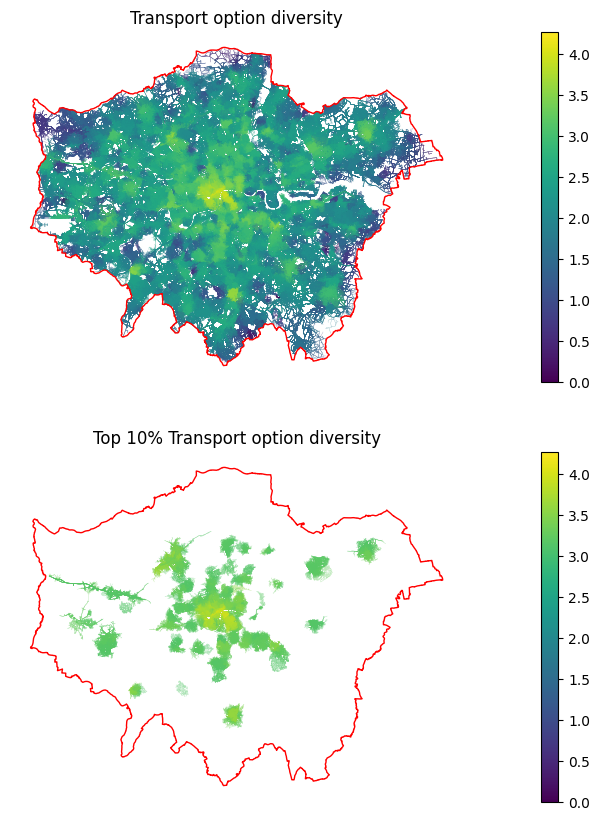

In [14]:
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = isochrones.transp_opt_entropy.min()
vmax = isochrones.transp_opt_entropy.max()

isochrones.plot(column='transp_opt_entropy', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('Transport option diversity')
ax[0].axis('off')

isochrones[isochrones.transp_opt_entropy > isochrones.transp_opt_entropy.quantile(0.90)].plot(
            column='transp_opt_entropy', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% Transport option diversity')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

In [12]:
isochrones_df = isochrones[['id_code','transp_opt_entropy','transp_opt_entropy_wo_hub']]
isochrones_df.reset_index(drop=True,inplace=True)

In [13]:
#export gdf
isochrones_df.to_csv(os.path.join('data','cleaned','transp_opt_isochrones.csv'),index=False)

In [11]:
isochrones.to_csv(os.path.join('data','cleaned','transp_opt_isochrones_full.csv'),index=False)